## JSON parser

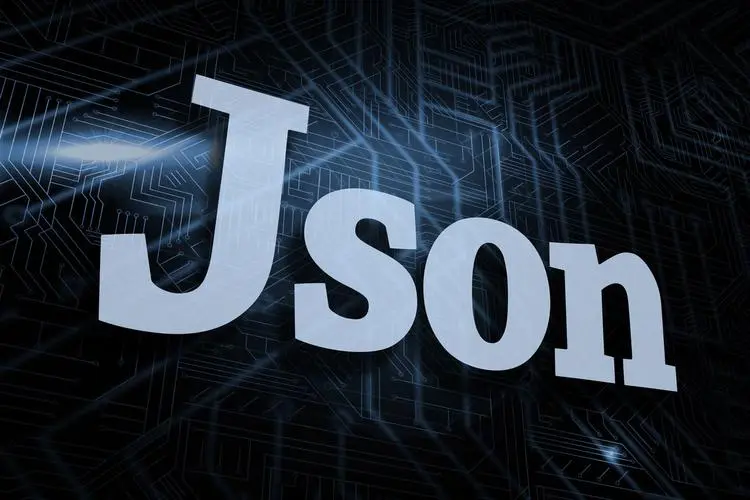

此输出解析器允许用户指定任意 JSON 架构并查询 LLMs 以获得符合该架构的输出。

请记住，大型语言模型是有漏洞的抽象！您必须使用具有足够容量的 LLM 来生成格式正确的 JSON。在OpenAI家族中，达芬奇可以可靠地完成任务，但居里的能力已经急剧下降。

您可以选择使用 Pydantic 来声明您的数据模型。

In [1]:
from typing import List

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
openai_api_key = "EMPTY"
openai_api_base = "http://127.0.0.1:1234/v1"
chat = ChatOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    temperature=0.3,
)

In [2]:
# 定义您想要的数据结构。
class Book(BaseModel):
    title: str = Field(description="书名")
    author: str = Field(description="作者")
    description: str = Field(description="书的简介")

In [14]:
# 以及旨在提示语言模型填充数据结构的查询。
query = "请给我介绍学习中国历史的经典书籍"

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Book)


format_instructions = parser.get_format_instructions()

format_instructions = '''输出应格式化为符合以下 JSON 结构的 JSON 实例。
JSON结构
```
{
'title': '书的标题',
'author': '作者',
'description': '书的简介'
}
```
'''
prompt = PromptTemplate(
    template="{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": format_instructions },
)

chain = prompt | chat | parser

chain.invoke({"query": query})

{'title': '《史记》',
 'author': '司马迁',
 'description': '《史记》是中国第一部纪传体通史，记载了上起黄帝下至汉武帝年间共三千多年的历史。它被列为二十四史之首，与后来的《汉书》、《后汉书》、《三国志》合称“前四史”，与《资治通鉴》并称为“史学双璧”。'}

In [17]:
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"title": {"title": "Title", "description": "\\u4e66\\u540d", "type": "string"}, "author": {"title": "Author", "description": "\\u4f5c\\u8005", "type": "string"}, "description": {"title": "Description", "description": "\\u4e66\\u7684\\u7b80\\u4ecb", "type": "string"}}, "required": ["title", "author", "description"]}\n```'

In [18]:
for s in chain.stream({"query": query}):
    print(s)

{}
{'title': ''}
{'title': '《'}
{'title': '《万'}
{'title': '《万历'}
{'title': '《万历十五'}
{'title': '《万历十五年'}
{'title': '《万历十五年》'}
{'title': '《万历十五年》', 'author': ''}
{'title': '《万历十五年》', 'author': '黄'}
{'title': '《万历十五年》', 'author': '黄仁'}
{'title': '《万历十五年》', 'author': '黄仁宇'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': ''}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以15'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以158'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1587'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1587年'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1587年为'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1587年为切入'}
{'title': '《万历十五年》', 'author': '黄仁宇', 'description': '本书以1587年为切入点'}
{'title': '《万历十五年》', 'author': '黄仁宇

## 修复输出解析器

此输出解析器包装另一个输出解析器，如果第一个输出解析器失败，它会调用另一个 LLM 来修复任何错误。

但除了抛出错误之外，我们还可以做其他事情。具体来说，我们可以将格式错误的输出以及格式化的指令传递给模型并要求其修复。

对于这个例子，我们将使用上面的 Pydantic 输出解析器。如果我们传递一个不符合模式的结果，会发生以下情况：

In [20]:
class Actor(BaseModel):
    name: str = Field(description="演员的名字")
    film_names: List[str] = Field(description="他们主演的电影名称列表")

In [22]:
from langchain.output_parsers import PydanticOutputParser
actor_query = "生成随机演员的电影作品表。"

parser = PydanticOutputParser(pydantic_object=Actor)

In [27]:
misformatted = "{'name': 'Tom Hanks', 'film_names': ['Forrest Gump']"
parser.parse(misformatted)

OutputParserException: Failed to parse Actor from completion {}. Got: 2 validation errors for Actor
name
  field required (type=value_error.missing)
film_names
  field required (type=value_error.missing)

In [28]:
from langchain.output_parsers import OutputFixingParser

new_parser = OutputFixingParser.from_llm(parser=parser, llm=chat)

In [29]:
new_parser.parse(misformatted)

Actor(name='Tom Hanks', film_names=['Forrest Gump'])